In [ ]:
# TODO:
#
# 1 - (DONE) Do FFT 
# 2 - Sort the frequencies to be in human vocal range to get a fixed 1D Vector size (Might be done in the function above)
# 2.5 - Apply threshold to the data (amplitudes) to remove all noise
# 3 - Put them in tensor format (data) with labels etc, so it can be used with pytorch classes and functions
# 4 - Create Augmentations for the dataset
# 5 - Create Datasets, validation sets, test sets, and loaders
# 6 - Modify the helper functions from class
# 7 - Create NN model
# 8 - Traind

# Normalize: constant vs relative
# Different sizes on audio snippets
#   - Maybe to make a 2 sec clip take 2 random 1 sec clip and fuse them together for robustness? I think This will be good!
# Tresholding amplitudes
# Augmentation of data

(500, 1024)
(500, 1024)
<class 'numpy.float64'>
(500, 1024)
Dataset size: (1500, 1024) Mu: 499807.71809846256 Sigma: 668905.3789442801
AudioMetaData(sample_rate=16000, num_frames=16000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


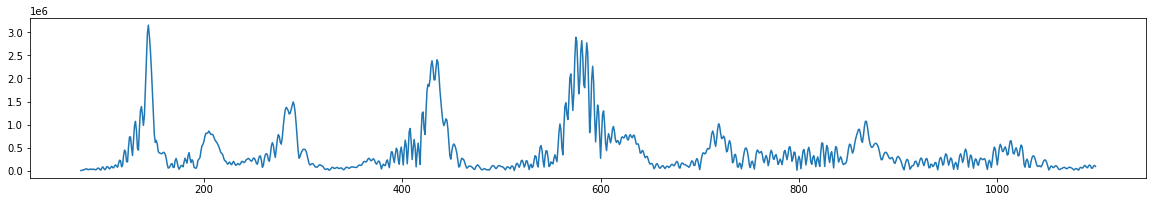

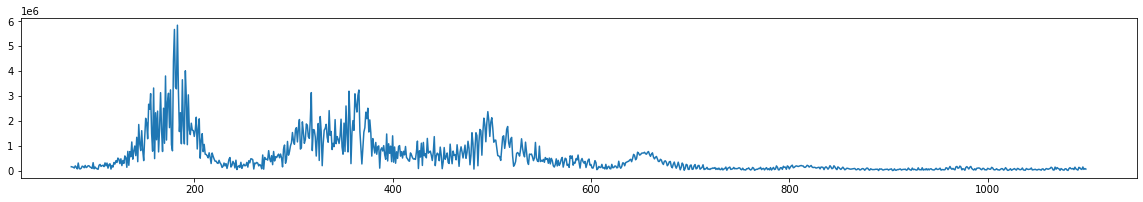

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
import glob
from pydub import AudioSegment
from pydub.utils import make_chunks
#from playsound import playsound
import torch
from torch.utils.data import Dataset
import torchaudio.transforms as transforms
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image 



# Source https://www.dpamicrophones.com/mic-university/facts-about-speech-intelligibility

vocal_range_start = 76
vocal_range_end = 1100
fft_human_size = vocal_range_end - vocal_range_start



#------------------------ CREATING DATASETS -----------------------------#


#print(len(os.listdir('0_both_1s')))
data_0_both_1s = np.empty([len(os.listdir('0_both_1s')), fft_human_size])
print(data_0_both_1s.shape)
#print(data_0_both_1s)
idx = 0
for filepath in glob.iglob('0_both_1s/*.wav'):
    #myaudio = AudioSegment.from_file(filepath , "wav")
    rate, data = wav.read(filepath)
    fft_out = np.abs(fft(data))
    yf_human = fft_out[vocal_range_start:vocal_range_end]
    #print(yf_human.shape)
    data_0_both_1s[idx] = yf_human
    idx = idx + 1
#print(data_0_both_1s)
#xf_human = range(100, 400)
#plt.figure(figsize=(20, 10))
#plt.subplot(311)
#plt.plot(xf_human, data_0_both_1s[])

data_1_esben_1s = np.empty([len(os.listdir('1_esben_1s')), fft_human_size])
idx = 0
for filepath in glob.iglob('1_esben_1s/*.wav'):
    rate, data = wav.read(filepath)
    fft_out = np.abs(fft(data))
    yf_human = fft_out[vocal_range_start:vocal_range_end]
    data_1_esben_1s[idx] = yf_human
    idx = idx + 1
print(data_1_esben_1s.shape)
print(type(data_1_esben_1s[0][0]))
xf_human = range(vocal_range_start, vocal_range_end)
plt.figure(figsize=(20, 10))
plt.subplot(311)
plt.plot(xf_human, data_1_esben_1s[155])

data_2_peter_1s = np.empty([len(os.listdir('2_peter_1s')), fft_human_size])
idx = 0
for filepath in glob.iglob('2_peter_1s/*.wav'):
    rate, data = wav.read(filepath)
    fft_out = np.abs(fft(data))
    yf_human = fft_out[vocal_range_start:vocal_range_end]
    data_2_peter_1s[idx] = yf_human
    idx = idx + 1
print(data_2_peter_1s.shape)

xf_human = range(vocal_range_start, vocal_range_end)
plt.figure(figsize=(20, 10))
plt.subplot(312)
plt.plot(xf_human, data_2_peter_1s[155])

full_data_set = np.concatenate((data_0_both_1s, data_1_esben_1s, data_2_peter_1s))
labels = np.concatenate((np.full((500,1), 0), np.full((500,1), 1), np.full((500,1), 2))) # Class label: 0 = both, 1 = esben, 2 = peter
#print(torch.tensor(full_data_set[0]).float().unsqueeze(0).shape)

# Calculate the mean and std:
mu = full_data_set.mean()
std = full_data_set.std()
print("Dataset size:", full_data_set.shape, "Mu:", mu, "Sigma:", std)

# ToTensor already maps 0-255 to 0-1, so devide mu and std by 255 below 
pitchshift_transform = transforms.PitchShift(16000, 4)
    
metadata = torchaudio.info('1_esben_1s/chunk5.wav')
print(metadata)   

class AudioPodcastDataset(Dataset):
     def __init__(self, data, labels, transform=None): 
         self.data = data
         self.labels = labels
         self.transform = transform

     def __len__(self):
         return len(self.data)
    
     def __getitem__(self, idx):
         x_data = torch.tensor(self.data[idx]).float().unsqueeze(0)
         y_label = torch.tensor(int(self.labels[idx]))

         if self.transform:
            x_data = self.transform(x_data)

         return (x_data, y_label)



In [3]:
# Hyperparameters
# in_channel = 1
# num_classes = 3
batch_size = 16

dataset_none = AudioPodcastDataset(full_data_set, labels)
dataset_transform = AudioPodcastDataset(full_data_set, labels, transform=pitchshift_transform)

complete_dataset = torch.utils.data.ConcatDataset([dataset_none, dataset_transform])   

#print(test_ob.__getitem__(499))
train_set, test_set, validation_set = torch.utils.data.random_split(complete_dataset, [2000, 500, 500])

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(dataset = validation_set, batch_size = batch_size, shuffle = True)

train_features, train_labels = next(iter(train_loader))
#print(train_features.shape())
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 1, 1024])
Labels batch shape: torch.Size([16])


In [4]:
def cnn_layer(in_channels, out_channels, kernal_size=3, stride=1, padding=1, 
                    use_batchnorm=True, pool=False):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernal_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm1d(out_channels) if use_batchnorm else nn.Identity(),
        nn.MaxPool1d(2, 2) if pool else nn.Identity(),
    )

In [5]:
def cnn_model(pool=False):
    s = 1 if pool else 2 
    return nn.Sequential(
        # [Batch size, 1, 1024] dataVector
        # nn.Linear(1024, 2048), 
        # nn.ReLU(True), 
        # nn.Linear(2048, 2048), 
        # nn.ReLU(True), 
        # nn.Linear(2048, 1024), 
        # nn.ReLU(True), 
        cnn_layer(1, 16, kernal_size=3, stride=s, padding=1, pool=pool), 
        cnn_layer(16, 32, kernal_size=3, stride=s, padding=1, pool=pool),
        cnn_layer(32, 64, kernal_size=3, stride=s, padding=1, pool=pool),
        cnn_layer(64, 128, kernal_size=3, stride=s, padding=1, pool=pool),
        nn.Flatten(),   # (1024/2/2/2/2) * 128 = 
        nn.Linear(8192, 2048), 
        nn.ReLU(True), 
        nn.Linear(2048, 512), 
        nn.ReLU(True), 
        # nn.BatchNorm1d(512),
        nn.Linear(512, 3), # (B, 3) logits 
    )

In [6]:
def one_epoch(model, data_loader, opt=None):
    device = next(model.parameters()).device
    train = False if opt is None else True
    model.train() if train else model.eval()
    losses, correct, total = [], 0, 0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            logits = model(x)
        loss = F.cross_entropy(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()
    return np.mean(losses), correct / total


def train(model, loader_train, loader_valid, lr=1e-3, max_epochs=30, weight_decay=0., patience=3):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_accuracy = 0
    best_valid_accuracy_epoch = 0

    t = tqdm(range(max_epochs))
    for epoch in t:
        train_loss, train_acc = one_epoch(model, loader_train, opt)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        valid_loss, valid_acc = one_epoch(model, loader_valid)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        t.set_description(f'train_acc: {train_acc:.2f}, valid_acc: {valid_acc:.2f}')

        if valid_acc > best_valid_accuracy:
            best_valid_accuracy = valid_acc
            best_valid_accuracy_epoch = epoch

        if epoch > best_valid_accuracy_epoch + patience:
            break
    t.set_description(f'best valid acc: {best_valid_accuracy:.2f}')

    return train_losses, train_accuracies, valid_losses, valid_accuracies


def plot_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    p = plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    #plt.ylim(0, 1000)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    p = plt.plot(train_accuracies, label='train')
    plt.plot(valid_accuracies, label='valid')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [7]:
# stride, no augmentation
model = cnn_model()
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
plot_history(*train(model, train_loader, validation_loader))

test_acc = one_epoch(model, test_loader)[1]
print(f'{test_acc * 100:.1f} % test accuracy')

  0%|          | 0/30 [00:00<?, ?it/s]

Feature batch shape: torch.Size([16, 1, 1024])
Labels batch shape: torch.Size([16])


KeyboardInterrupt: 